# Use QR-DQN to Play Pong

TensorFlow version

In [1]:
%matplotlib inline

import copy
import logging
import itertools
import sys

import numpy as np
np.random.seed(0)
import pandas as pd
import gym
from gym.wrappers.atari_preprocessing import AtariPreprocessing
from gym.wrappers.frame_stack import FrameStack
import matplotlib.pyplot as plt
import tensorflow.compat.v2 as tf
tf.random.set_seed(0)
from tensorflow import keras
from tensorflow import nn
from tensorflow import optimizers
from tensorflow import losses
from tensorflow.keras import layers
from tensorflow.keras import models

logging.basicConfig(level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

Environment

In [2]:
env = gym.make('PongNoFrameskip-v4')
env = FrameStack(AtariPreprocessing(env), num_stack=4)
for key in vars(env):
    logging.info('%s: %s', key, vars(env)[key])
for key in vars(env.spec):
    logging.info('%s: %s', key, vars(env.spec)[key])

00:07:33 [INFO] env: <AtariPreprocessing<TimeLimit<AtariEnv<PongNoFrameskip-v4>>>>
00:07:33 [INFO] action_space: Discrete(6)
00:07:33 [INFO] observation_space: Box([[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]], [[[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]

 [[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 25

Agent

In [3]:
class DQNReplayer:
    def __init__(self, capacity):
        self.memory = pd.DataFrame(index=range(capacity),
                columns=['state', 'action', 'reward', 'next_state', 'terminated'])
        self.i = 0
        self.count = 0
        self.capacity = capacity

    def store(self, *args):
        self.memory.loc[self.i] = np.asarray(args, dtype=object)
        self.i = (self.i + 1) % self.capacity
        self.count = min(self.count + 1, self.capacity)

    def sample(self, size):
        indices = np.random.choice(self.count, size=size)
        return (np.stack(self.memory.loc[indices, field]) for field in
                self.memory.columns)

In [4]:
class QRDQNAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.gamma = 0.99
        self.epsilon = 1.

        self.replayer = DQNReplayer(capacity=100000)

        quantile_count = 64
        self.cumprob_tensor = tf.range(1 / (2 * quantile_count),
                1, 1 / quantile_count)[np.newaxis, :, np.newaxis]

        self.evaluate_net = self.build_net(self.action_n, quantile_count)
        self.target_net = models.clone_model(self.evaluate_net)

    def build_net(self, action_n, quantile_count):
        net = keras.Sequential([
                layers.Permute((2, 3, 1), input_shape=(4, 84, 84)),
                layers.Conv2D(32, kernel_size=8, strides=4, activation=nn.relu),
                layers.Conv2D(64, kernel_size=4, strides=2, activation=nn.relu),
                layers.Conv2D(64, kernel_size=3, strides=1, activation=nn.relu),
                layers.Flatten(),
                layers.Dense(512, activation=nn.relu),
                layers.Dense(action_n * quantile_count),
                layers.Reshape((action_n, quantile_count))])
        optimizer = optimizers.Adam(0.0001)
        net.compile(optimizer=optimizer)
        return net

    def reset(self, mode=None):
        self.mode = mode
        if mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, terminated):
        state_tensor = tf.convert_to_tensor(np.array(observation)[np.newaxis],
                dtype=tf.float32)
        q_component_tensor = self.evaluate_net(state_tensor)
        q_tensor = tf.reduce_mean(q_component_tensor, axis=2)
        action_tensor = tf.math.argmax(q_tensor, axis=1)
        actions = action_tensor.numpy()
        action = actions[0]
        if self.mode == 'train':
            if np.random.rand() < self.epsilon:
                action = np.random.randint(0, self.action_n)

            self.trajectory += [observation, reward, terminated, action]
            if len(self.trajectory) >= 8:
                state, _, _, act, next_state, reward, terminated, _ = \
                        self.trajectory[-8:]
                self.replayer.store(state, act, reward, next_state, terminated)
            if self.replayer.count >= 1024 and self.replayer.count % 10 == 0:
                self.learn()
        return action

    def close(self):
        pass

    def update_net(self, target_net, evaluate_net, learning_rate=0.005):
        average_weights = [(1. - learning_rate) * t + learning_rate * e for t, e
                in zip(target_net.get_weights(), evaluate_net.get_weights())]
        target_net.set_weights(average_weights)

    def learn(self):
        # replay
        batch_size = 32
        states, actions, rewards, next_states, terminateds = \
                self.replayer.sample(batch_size)
        state_tensor = tf.convert_to_tensor(states, dtype=tf.float32)
        reward_tensor = tf.convert_to_tensor(rewards[:, np.newaxis],
                dtype=tf.float32)
        terminated_tensor = tf.convert_to_tensor(terminateds[:, np.newaxis],
                dtype=tf.float32)
        next_state_tensor = tf.convert_to_tensor(next_states, dtype=tf.float32)

        # compute target
        next_q_component_tensor = self.evaluate_net(next_state_tensor)
        next_q_tensor = tf.reduce_mean(next_q_component_tensor, axis=2)
        next_action_tensor = tf.math.argmax(next_q_tensor, axis=1)
        next_actions = next_action_tensor.numpy()
        all_next_q_quantile_tensor = self.target_net(next_state_tensor)
        indices = [[idx, next_action] for idx, next_action in
                enumerate(next_actions)]
        next_q_quantile_tensor = tf.gather_nd(all_next_q_quantile_tensor,
                indices)
        target_quantile_tensor = reward_tensor + self.gamma \
                * next_q_quantile_tensor * (1. - terminated_tensor)

        with tf.GradientTape() as tape:
            all_q_quantile_tensor = self.evaluate_net(state_tensor)
            indices = [[idx, action] for idx, action in enumerate(actions)]
            q_quantile_tensor = tf.gather_nd(all_q_quantile_tensor, indices)

            target_quantile_tensor = target_quantile_tensor[:, np.newaxis, :]
            q_quantile_tensor = q_quantile_tensor[:, :, np.newaxis]
            td_error_tensor = target_quantile_tensor - q_quantile_tensor
            abs_td_error_tensor = tf.math.abs(td_error_tensor)
            hubor_delta = 1.
            hubor_loss_tensor = tf.where(abs_td_error_tensor < hubor_delta,
                    0.5 * tf.square(td_error_tensor),
                    hubor_delta * (abs_td_error_tensor - 0.5 * hubor_delta))
            comparison_tensor = tf.cast(td_error_tensor < 0, dtype=tf.float32)
            quantile_regression_tensor = tf.math.abs(self.cumprob_tensor -
                    comparison_tensor)
            quantile_huber_loss_tensor = tf.reduce_mean(tf.reduce_sum(
                    hubor_loss_tensor * quantile_regression_tensor, axis=-1),
                    axis=1)
            loss_tensor = tf.reduce_mean(quantile_huber_loss_tensor)
        grads = tape.gradient(loss_tensor, self.evaluate_net.variables)
        self.evaluate_net.optimizer.apply_gradients(
                zip(grads, self.evaluate_net.variables))

        self.update_net(self.target_net, self.evaluate_net)

        self.epsilon = max(self.epsilon - 1e-5, 0.05)


agent = QRDQNAgent(env)

Train & Test

00:07:35 [INFO] ==== train ====
00:07:58 [INFO] train episode 0: reward = -17.00, steps = 1265
00:08:23 [INFO] train episode 1: reward = -21.00, steps = 762
00:08:53 [INFO] train episode 2: reward = -20.00, steps = 960
00:09:18 [INFO] train episode 3: reward = -21.00, steps = 791
00:09:45 [INFO] train episode 4: reward = -21.00, steps = 875
00:10:10 [INFO] train episode 5: reward = -21.00, steps = 820
00:10:36 [INFO] train episode 6: reward = -21.00, steps = 878
00:10:58 [INFO] train episode 7: reward = -19.00, steps = 934
00:11:17 [INFO] train episode 8: reward = -20.00, steps = 837
00:11:39 [INFO] train episode 9: reward = -20.00, steps = 956
00:12:09 [INFO] train episode 10: reward = -21.00, steps = 987
00:12:35 [INFO] train episode 11: reward = -20.00, steps = 861
00:12:59 [INFO] train episode 12: reward = -21.00, steps = 758
00:13:29 [INFO] train episode 13: reward = -19.00, steps = 956
00:13:56 [INFO] train episode 14: reward = -21.00, steps = 846
00:14:25 [INFO] train episode 15

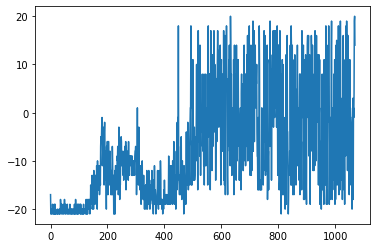

In [5]:
def play_episode(env, agent, seed=None, mode=None, render=False):
    observation, _ = env.reset(seed=seed)
    reward, terminated, truncated = 0., False, False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, terminated)
        if render:
            env.render()
        if terminated or truncated:
            break
        observation, reward, terminated, truncated, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env, agent, mode='train')
    episode_rewards.append(episode_reward)
    logging.info('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-3:]) > 16.:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.info('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))